## PyRMS test script

simple test script for executing rms from python, for use in the uncertainty pipeline. rms does sensitivities faster


In [1]:
from pyrms import rms
from diffeqpy import de
from julia import Main
import yaml
from julia import Sundials
from diffeqpy import de
import time 
import matplotlib
from copy import deepcopy
from rmgpy.chemkin import load_chemkin_file
from rmgpy.rmg.model import ReactionModel
from rmgpy.species import Species
from rmgpy.kinetics import StickingCoefficientBEP, StickingCoefficient, SurfaceArrheniusBEP, SurfaceArrhenius
from rmgpy.data.kinetics.database import KineticsDatabase
import os
import copy
%matplotlib inline

In [2]:
file_dir = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/rmg_gua/baseline/rms/chem32.rms"
phase_dict = rms.readinput(file_dir)

In [3]:
base_path = "/".join(file_dir.split("/")[:-2])
base_path = os.path.join(base_path, "chemkin")
cmkn_path = os.path.join(base_path, "chem_annotated-gas.inp")
cmkn_surf_path = os.path.join(base_path, "chem_annotated-surface.inp")
cmkn_dict_path = os.path.join(base_path, "species_dictionary.txt")
# file_dir.replace(file_dir.split("/")[-1], "/chemkin")

In [4]:
expt_condts = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/rmg_gua/gua_cantera/all_experiments_reorg_sbr.yaml"

with open(expt_condts, 'r') as file:
    data = yaml.safe_load(file)

# pick just one experiment for example 
conditions = data[2]

# convert volume flow to molar flow
conditions["volume_flowrate"]

FC_temp = 293.15
conditions["molar_flow"] = conditions["volume_flowrate"] * 1.01325e5 / (8.3145 * FC_temp) 

In [5]:
intfc_key = list(phase_dict.keys())[0]

# mechanism dictionaries index:  phase_dict[phasename]["Species" or "Reactions"]
gasspcs = phase_dict["gas"]["Species"]
gasrxns = phase_dict["gas"]["Reactions"]
surfacespcs = phase_dict["surface"]["Species"]
surfacerxns = phase_dict["surface"]["Reactions"]
interfacerxns = phase_dict[intfc_key]["Reactions"]

In [6]:
#Define the phase (how species thermodynamic and kinetic properties calculated)
ig = rms.IdealGas(gasspcs,gasrxns,name="gas") 
cat = rms.IdealSurface(surfacespcs, surfacerxns, 2.943e-5, name="surface")

In [7]:
# Set simulation gas Initial Temp and Pressure
initialcondsgas = {
        "T":conditions["temperature"],
        "P":conditions["pressure"],
        "CO":conditions["species"]["CO"],
        "CO2":conditions["species"]["CO2"],
        "H2":conditions["species"]["H2"],
} 
# Define the domain (encodes how system thermodynamic properties calculated)
domaingas,y0gas,pgas = rms.ConstantTPDomain(phase=ig,initialconds=initialcondsgas,sensitivity=True)

In [8]:
# Set simulation surf Initial Temp and Pressure
V = conditions["volume"]
A = conditions["catalyst_area"]
initialconds = {
        "T":conditions["temperature"],
        "A":conditions["catalyst_area"],
        "X":cat.sitedensity*A
} 
# Define the domain (encodes how system thermodynamic properties calculated)
domaincat,y0cat,pcat = rms.ConstantTAPhiDomain(phase=cat,initialconds=initialconds,sensitivity=True);

## make reactor, inlet and outlet
- makes an anonymous function x->42, is that velocity in? need to check if it is velocity or volume flowrate
- also, I think the ```phi``` refers to chemical potential, but I should check, I think constantTPhi is just const T for our case. 

In [9]:
initialcondsinlet = {
        "T":conditions["temperature"],
        "P":conditions["pressure"],
        "CO":conditions["species"]["CO"],
        "CO2":conditions["species"]["CO2"],
        "H2":conditions["species"]["H2"],
    }

# construct reactor
inter,pinter = rms.ReactiveInternalInterfaceConstantTPhi(domaingas,domaincat,interfacerxns,initialcondsinlet["T"],A);

# make inlet and outlet
inletgas = rms.Inlet(domaingas,initialcondsinlet,Main.eval("x->"+str(conditions["molar_flow"])))
outletgas = rms.Outlet(domaingas,Main.eval("x->"+str(conditions["molar_flow"])))

In [10]:
# Define domains and interfaces
domains = (domaingas,domaincat)
interfaces = [inter,inletgas,outletgas]

# create a reactor for the system
react,y0,p = rms.Reactor(domains,(y0gas,y0cat),(0.0,100),interfaces,(pgas,pcat,pinter)) # Create the reactor object

In [11]:
# run the simulation
t1 = time.time()
sol = de.solve(react.ode,de.CVODE_BDF(),abstol=1e-20,reltol=1e-8)
t2 = time.time()
print("elapsed time for sim: ", t2-t1)

elapsed time for sim:  38.91900944709778


In [12]:
ssys = rms.SystemSimulation(sol,domains,interfaces,p)

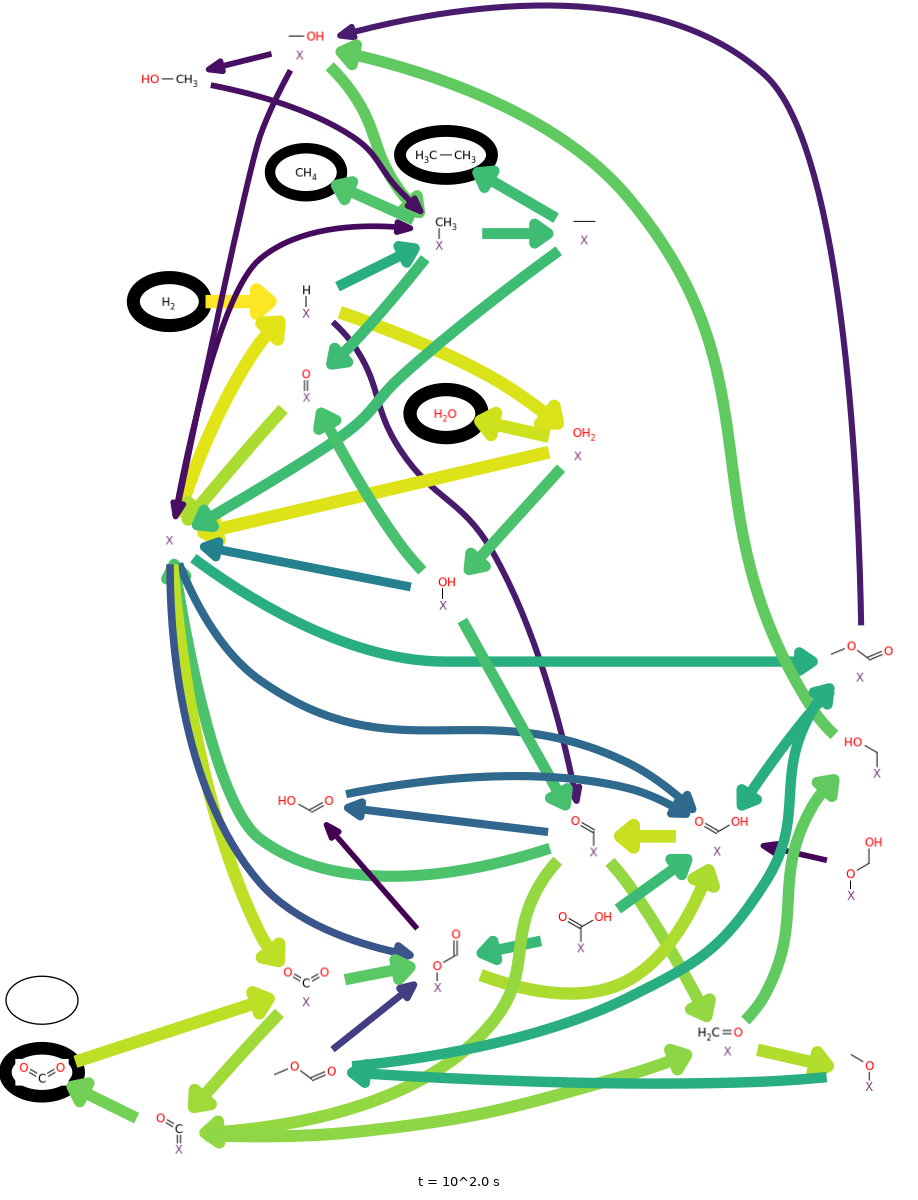

In [20]:
rms.getfluxdiagram(ssys,100)

In [13]:
results = {}
gas_names = ssys.sims[0].names
gas_moles = rms.molefractions(ssys.sims[0], 100)
for (name, moles) in zip(gas_names, gas_moles):
    results[name] = moles

# surface
surf_names = ssys.sims[1].names
surf_moles = rms.molefractions(ssys.sims[1],  100)
for (name, moles) in zip(surf_names, surf_moles):
    results[name] = moles


In [14]:
len(gas_moles) ==len(gas_names)

True

In [15]:
results

{'N2': 0.0,
 'Ne': 0.0,
 'H2': 0.27747172775400053,
 'CO': 0.08845737904170611,
 'CO2': 0.17499773970571628,
 'H2O': 0.36018710015275607,
 'CH2O': 4.651758016215597e-09,
 'HCOOH': 1.8800762246257253e-07,
 'CH3OH': 3.662667315540158e-08,
 'HCOOCH3': 2.2334455020176037e-10,
 'CH4': 0.018737180616759892,
 'CC': 0.08014864321966302,
 'X': 0.6094138572703082,
 'H*': 0.015416299671068641,
 'O*': 1.3173125228745576e-09,
 'OH*': 1.1767304527976334e-11,
 'H2O*': 0.018481062920451624,
 'CO*': 0.0022548300165607517,
 'CO2*': 0.046712179765450654,
 'HCO*': 1.6729819238715195e-05,
 'HCOO*': 0.00016327773201821213,
 'COOH*': 4.745605648213372e-06,
 'HCOOH*': 1.9434222205879857e-05,
 'CH2O*': 2.3228240493640657e-06,
 'CH3O*': 3.225302004977396e-11,
 'CH3O2*': 5.212001893288062e-15,
 'CH3OH*': 2.193213919157714e-08,
 'COC=O.[Pt]': 5.4572642025268866e-08,
 'OC[Pt]': 1.619327315243936e-07,
 'CH3X': 7.754417639352616e-10,
 'CC.[Pt]': 0.3075150195597425,
 'CC[Pt]': 1.8964713845379916e-11}

In [16]:
rms.molefractions(ssys.sims[0], "CO", 100)

0.08845737904170611

In [17]:
# load the chemkin file for the mechanism
chemkin_file = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/rmg_gua/baseline/chemkin/chem_annotated-gas.inp"
chemkin_surf_file = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/rmg_gua/baseline/chemkin/chem_annotated-surface.inp"
chemkin_dict = "/work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/rmg_gua/baseline/chemkin/species_dictionary.txt"
model = ReactionModel()

model.species, model.reactions = load_chemkin_file(
    chemkin_file,
    chemkin_dict, 
    surface_path=chemkin_surf_file,
    )

In [18]:
def make_spc(spc): 
    """
    make an RMG object from the rms object
    
    """
    if len(spc.adjlist) > 0:
        rmg_spc = Species().from_adjacency_list(spc.adjlist)
    else: 
        rmg_spc = Species().from_smiles(spc.smiles)

    return rmg_spc

In [ ]:
sens_times = [1e-2, 3e-2, 100]
sens_rxn_dict = {}
max_len = 0
# get the ordering of reactions that are sensitive to CH3OH at different time scales. 
# our ordering is from highest sensitivity to low. so, start at one. if it is 
# found to be the first most sensitive at the first time value, then the 5th most sensitive at the 
# second time value, then the tenth at the third time value then the score it gets is 
# 1*5*10 = 50

for time in sens_times:
    sens_rxns, rxn_sens = rms.getrxntransitorysensitivities(ssys, "CH3OH", time, tol = 0)
    counter = 1
    for (rxn, sens) in zip(sens_rxns, rxn_sens):
        if rms.getrxnstr(rxn) in sens_rxn_dict.keys():
            old_sens = sens_rxn_dict[rms.getrxnstr(rxn)][0]
            sens_rxn_dict[rms.getrxnstr(rxn)][0] = counter*old_sens
            sens_rxn_dict[rms.getrxnstr(rxn)][1].append(sens)
            sens_rxn_dict[rms.getrxnstr(rxn)][2].append(counter)
        else:
            # print("reac str: ", rms.getrxnstr(rxn))
            # rxn_adj = rms.getrxnadjlist(rxn)
            # rxn_smiles = rms.getrxnsmiles(rxn)
            # print(rxn_smiles)
            reac_spec = [make_spc(reac) for reac in rxn.reactants]
            prod_spec = [make_spc(prod) for prod in rxn.products]
            sens_rxn_dict[rms.getrxnstr(rxn)] = [counter, [sens],[counter], reac_spec, prod_spec]

        counter +=1
    if len(sens_rxns) > max_len:
        max_len = len(sens_rxns)
    
# go through values in sens rxn dict that have fewer than len(sens_times) values 
# and multiply by max_len + 1. 
# penalizing for only being sensitive at one time point
for rxn in sens_rxn_dict.keys():
    if len(sens_rxn_dict[rxn][1]) < len(sens_times):
        sens_rxn_dict[rxn][0] *= (max_len + 1)
        for i in range(len(sens_times) - len(sens_rxn_dict[rxn][1])):
            sens_rxn_dict[rxn][1].append(0)
            sens_rxn_dict[rxn][2].append(max_len + 1)
            
# sort the dictionary by the score
sens_rxn_dict = {k: v for k, v in sorted(sens_rxn_dict.items(), key=lambda item: item[1][0])}

# print the dict: 
for rxn_str, entry in sens_rxn_dict.items():
    print(rxn_str, entry[0])

In [ ]:
# now match up the rms reaction sensitivities with the actual rxn in chemkin
# match species does forward and reverse. if there are multiple matches, it will
# print a warning.
match_list = []
sens_cmkn_dict = {}
for rxn_str, entry in sens_rxn_dict.items():
    for rxn in model.reactions:
        counter = 0
        if rxn.matches_species(entry[3],entry[4]):
            print("match : ", rxn_str, counter)
            match_list.append(rxn_str)
            sens_cmkn_dict[rxn_str] = (entry[0], rxn)
        counter += 1
        if counter >=2: 
            print("more than 1 match found for ", rxn_str)
if len(match_list) == len(sens_rxn_dict.keys()):
    print("all matches found")
else: 
    for rxn_str, entry in sens_rxn_dict.items():
        if rxn_str not in match_list:
            print("no match found for ", rxn_str)

In [ ]:
min_key = min(sens_cmkn_dict, key=sens_cmkn_dict.get)
most_sens_rxn = sens_cmkn_dict[min_key][1]

In [ ]:
most_sens_rxn.kinetics

In [ ]:
most_sens_rxn_copy = copy.deepcopy(sens_cmkn_dict)
most_sens_rxn_copy.pop(min_key)

try: 
    popped_key = most_sens_rxn_copy[min_key]
except KeyError:
    print("key not found")

## make a script 